In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
!pip install contractions
import contractions

import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv('/content/sample.csv')

In [4]:
df.shape

(50000, 7)

Preprocessing

In [41]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,332118,332118,459096,459097,Why do people give presents/gifts?,Why do people give gifts?,1
1,206192,206192,18301,31494,How should one improve one's presence of mind?,How can I improve my presence of mind and conc...,1
2,161099,161099,103466,163516,What are the best pics clicked on a phone?,What are some of the best photos taken from a ...,1
3,183218,183218,171641,280226,Why makes a woman attractive according to you?,What makes a big woman attractive?,0
4,99948,99948,165852,165853,Which is the biological purpose of a yawn?,Why does yawning occurs?,0


In [67]:
def preprocess(q):
  q = str(q).lower().strip()
  q = contractions.fix(q) ## correcting the contractions
  q = re.sub(r"https?://\S+|www\.\S+", "", q) ## remove the urls from string
  html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")  ##removing the html tags
  q = re.sub(html, "", q)
  #replace certain special characters
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar')
  q = q.replace('₹', ' rupee ')
  q = q.replace('@', ' at')
  q = q.replace('€', ' euro')
  q = q.replace('[math]','')
  q = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", q) ##puntuation
  return q


In [68]:
##example
preprocess("What's the default password for an AT&T Uverse router?")

'what is the default password for an att uverse router'

In [69]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [62]:
df.head(10)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,332118,332118,459096,459097,why do people give presentsgifts,why do people give gifts,1
1,206192,206192,18301,31494,how should one improve ones presence of mind,how can i improve my presence of mind and conc...,1
2,161099,161099,103466,163516,what are the best pics clicked on a phone,what are some of the best photos taken from a ...,1
3,183218,183218,171641,280226,why makes a woman attractive according to you,what makes a big woman attractive,0
4,99948,99948,165852,165853,which is the biological purpose of a yawn,why does yawning occurs,0
5,83049,83049,140693,140694,what is a typical week for a wwe superstar,how much wwe earn per weekly raw show,0
6,230231,230231,127402,339712,why do instagram and snapchat not let me use c...,how can i get my parents to let me get a snapchat,0
7,87247,87247,146975,132664,how do i end an affair with an older married m...,how do i end your affair with an older married...,1
8,403259,403259,81775,536827,why do not people just shoot captain america b...,it seems like captain america shield is so str...,0
9,41662,41662,21324,72976,why do so many people hate hillary clinton,how is it that people hate hillary clinton,1


In [70]:
#basic feature engg
##length of each question
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()
##Number of words in each questions
df['q1_num_words'] = df['question1'].apply(lambda row : len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row : len(row.split(" ")))
##common words
def common_words(row):
  w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(' ')))
  w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(' ')))
  return len(w1&w2)
def total_words(row):
  w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(' ')))
  w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(' ')))
  return (len(w1) + len(w2))
df['num_common_words'] = df.apply(common_words ,axis=1)
df['num_total_words'] = df.apply(total_words , axis=1)
df['word_share'] = round(df['num_common_words']/df['num_total_words'] ,2)

In [71]:
df.head(5)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,num_common_words,num_total_words,word_share
0,332118,332118,459096,459097,why do people give presents gifts,why do people give gifts,1,33,24,6,5,5,11,0.45
1,206192,206192,18301,31494,how should one improve ones presence of mind,how can i improve my presence of mind and conc...,1,44,55,8,10,5,18,0.28
2,161099,161099,103466,163516,what are the best pics clicked on a phone,what are some of the best photos taken from a ...,1,41,56,9,12,6,21,0.29
3,183218,183218,171641,280226,why makes a woman attractive according to you,what makes a big woman attractive,0,45,33,8,6,4,14,0.29
4,99948,99948,165852,165853,which is the biological purpose of a yawn,why does yawning occurs,0,41,23,8,4,0,12,0.00


**Advance Feature Engg** 

**Token Features**
1. Common word count min(cwc-min) - # common words/min(words(q1,q2))
2. Common word count max(cwc-max) - # common words/max(words(q1,q2))
3. Common stopword count(csc-min) - # common stopwords/min(words(q1,q2))
4. Common stopword count(csc-max) - # common stopwords/max(words(q1,q2))
5. Common tokens count(ctc-min) - # common tokens/min(words(q1,q2))
6. Common tokens count(ctc-min) - # common tokens/max(words(q1,q2))
7. Last word equivqlent
8. First word equivqlent

**Length Features**
1. Mean length
2. Abs length diff
3. Longest substring

**Fuzzy Features**
link -https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

1. fuzz_ratio 
2. fuzz_partial_ratio
3. token_sort_ratio
4. token_set_ratio




In [77]:
#token features
import nltk
from nltk.corpus import stopwords
NUM_TOKEN_FEATURE = 8
nltk.download('stopwords')
def fetch_token_features(row):
  q1 = row['question1']
  q2 = row['question2']

  SAFE_DIV = 0.0001

  STOP_WORDS = stopwords.words('english')

  token_features = [0.0]*NUM_TOKEN_FEATURE
  ##converting token to features
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  ##getting the non stopwords form the questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  ##getting the stop words in the tokens
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  ##common word count
  common_word_count = len(q1_words.intersection(q2_words))
  ##common stopwords count
  common_stopword_count = len(q1_stops.intersection(q2_stops))
  #common token count
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
  # cwc-min - common words/min(words(q1,q2))
  token_features[0] = common_word_count / (min(len(q1_words),len(q2_words)) + SAFE_DIV)
  # cwc-max - common words/max(words(q1,q2))
  token_features[1] = common_word_count / (max(len(q1_words),len(q2_words)) + SAFE_DIV)
  # csc-min - common stopwords/min(words(q1,q2))
  token_features[2] = common_stopword_count / (min(len(q1_stops),len(q2_stops)) + SAFE_DIV)
  # csc-max - common stopwords/max(words(q1,q2))
  token_features[3] = common_stopword_count / (max(len(q1_stops),len(q2_stops)) + SAFE_DIV)
  #ctc-min  common tokens/min(words(q1,q2))
  token_features[4] = common_token_count / (min(len(q1_tokens) , len(q2_tokens)) + SAFE_DIV)
  #ctc-max  common tokens/max(words(q1,q2))
  token_features[5] = common_token_count / (max(len(q1_tokens) , len(q2_tokens)) + SAFE_DIV)
  ##check first word is similar
  token_features[6] = int(q1_tokens[0]==q2_tokens[0])
  ##check last word is similar
  token_features[7] = int(q1_tokens[-1]==q2_tokens[-1])

  return token_features

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
token_features = df.apply(fetch_token_features, axis =1)
df['cwc_min'] = list(map(lambda x:x[0] , token_features))
df['cwc_max'] = list(map(lambda x:x[1] , token_features))
df['csc_min'] = list(map(lambda x:x[2] , token_features))
df['csc_max'] = list(map(lambda x:x[3] , token_features))
df['ctc_min'] = list(map(lambda x:x[4] , token_features))
df['ctc_max'] = list(map(lambda x:x[5] , token_features))
df['first_word_similar'] = list(map(lambda x:x[6] , token_features))
df['last_word_similar'] = list(map(lambda x:x[7] , token_features))

In [82]:
df.shape

(50000, 22)

In [ ]:
!pip install distance

In [85]:
import distance
##length features
def fetch_length_features(row):
  q1 = row['question1']
  q2 = row['question2']

  length_features = [0.0]*3

  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return length_features

  ##absolute length features diff
  length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

  ##avg token length of both questions
  length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

  strs = list(distance.lcsubstrings(q1,q2))
  length_features[2] = len(strs[0]) / (min(len(q1),len(q2))+1)

  return length_features


In [86]:
length_features = df.apply(fetch_length_features , axis=1)
df['abs_len_diff'] = list(map(lambda x : x[0] , length_features))
df['mean_len'] = list(map(lambda x : x[1] , length_features))
df['longest_substr_ratio'] = list(map(lambda x : x[2] , length_features))

In [90]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from fuzzywuzzy import fuzz
def fetch_fuzzy_feature(row):
  q1 = row['question1']
  q2 = row['question2']

  fuzzy_features = [0.0]*4
  #fuzz Qratio
  fuzzy_features[0] = fuzz.QRatio(q1,q2)
  #fuzz partial ratio
  fuzzy_features[1] = fuzz.partial_ratio(q1,q2)
  #token sort ratio
  fuzzy_features[2] = fuzz.token_sort_ratio(q1,q2)
  ##token set ratio
  fuzzy_features[3] = fuzz.token_set_ratio(q1,q2)

  return fuzzy_features 

In [94]:
fuzzy_features = df.apply(fetch_fuzzy_feature ,axis=1)
df['qratio'] = list(map(lambda x : x[0] , fuzzy_features))
df['partial_ratio'] = list(map(lambda x : x[1] , fuzzy_features))
df['sort_ratio'] = list(map(lambda x : x[2] , fuzzy_features))
df['set_ratio'] = list(map(lambda x : x[3] , fuzzy_features))

In [96]:
df.shape

(50000, 29)

In [99]:
df.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words',
       'num_common_words', 'num_total_words', 'word_share', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'first_word_similar', 'last_word_similar', 'abs_len_diff', 'mean_len',
       'longest_substr_ratio', 'qratio', 'partial_ratio', 'sort_ratio',
       'set_ratio'],
      dtype='object')

Data Analysis on Advance features

In [98]:
import seaborn as sns

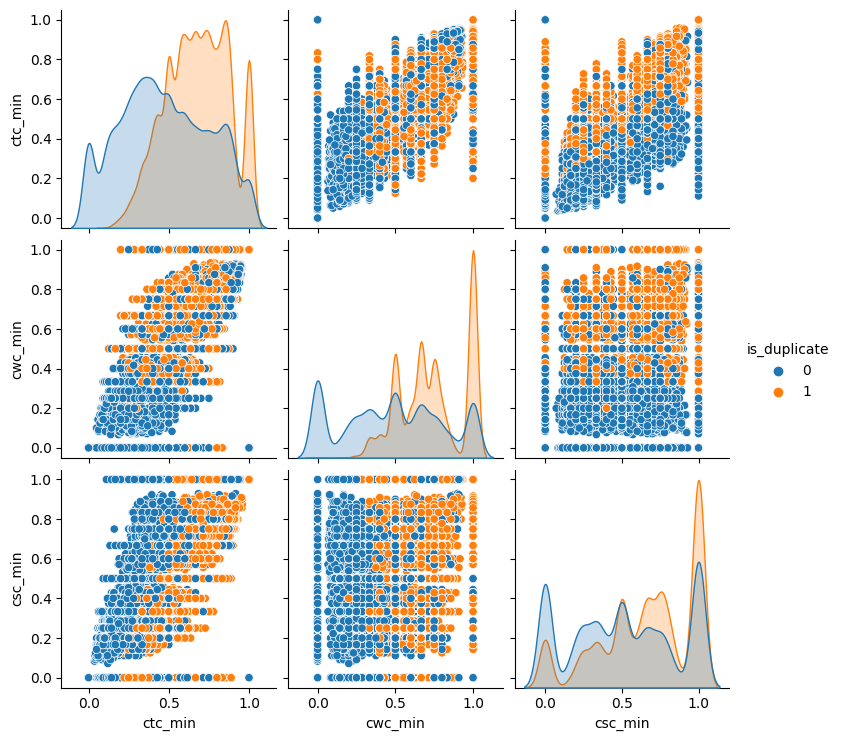

In [100]:
sns.pairplot(df[['ctc_min','cwc_min','csc_min','is_duplicate']],hue='is_duplicate')

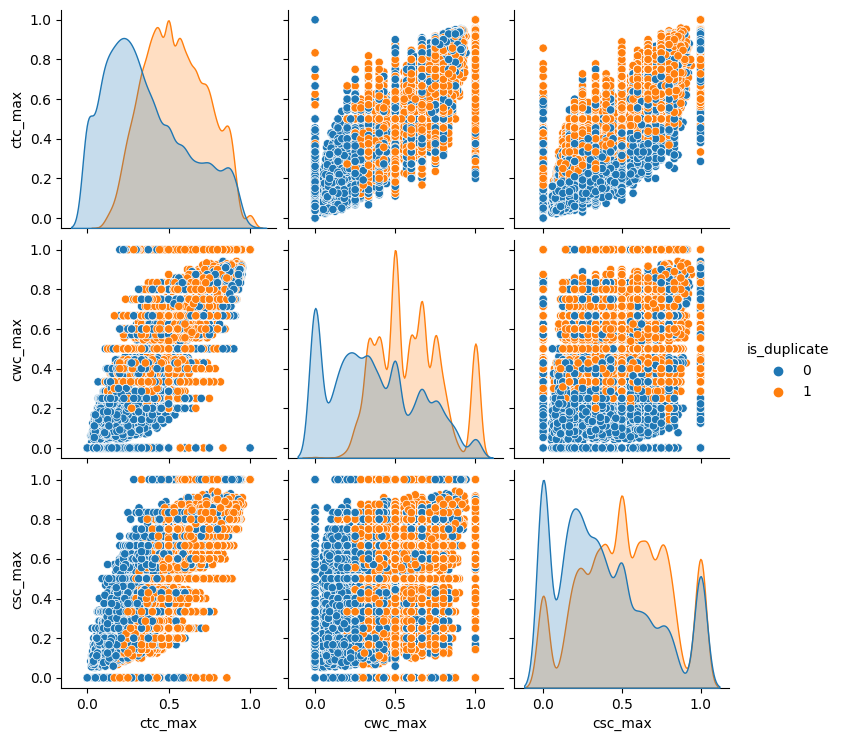

In [101]:
sns.pairplot(df[['ctc_max','cwc_max','csc_max','is_duplicate']],hue='is_duplicate')

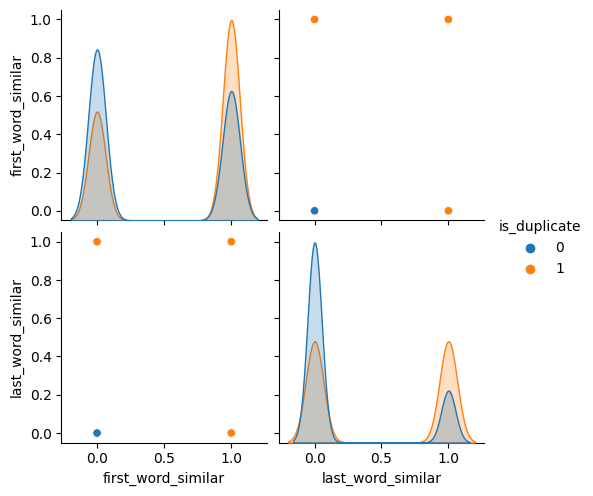

In [103]:
sns.pairplot(df[['first_word_similar','last_word_similar' ,'is_duplicate']] ,hue='is_duplicate')

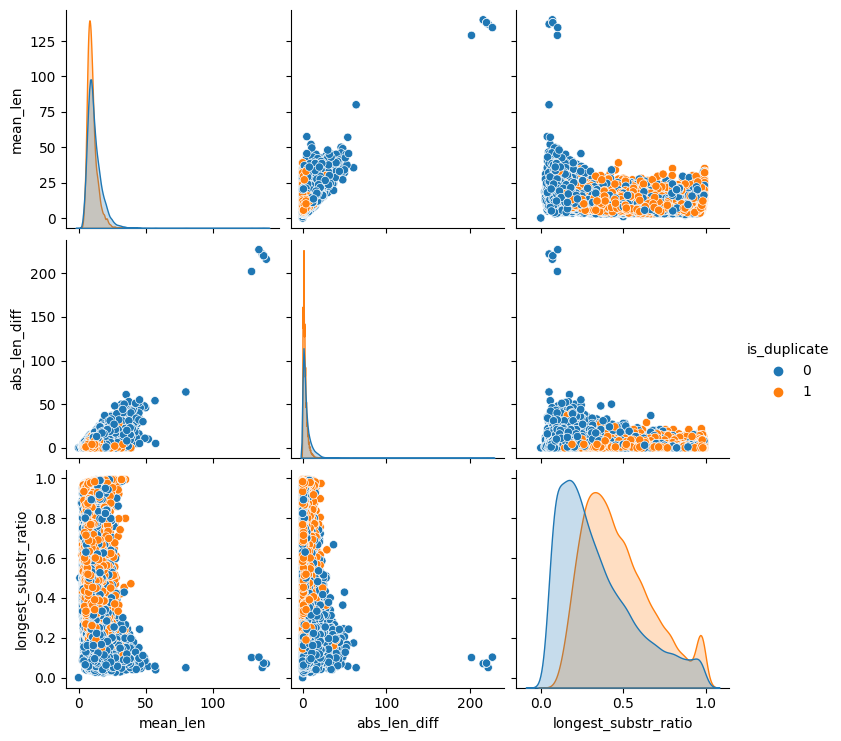

In [104]:
sns.pairplot(df[['mean_len','abs_len_diff','longest_substr_ratio','is_duplicate']] ,hue='is_duplicate')

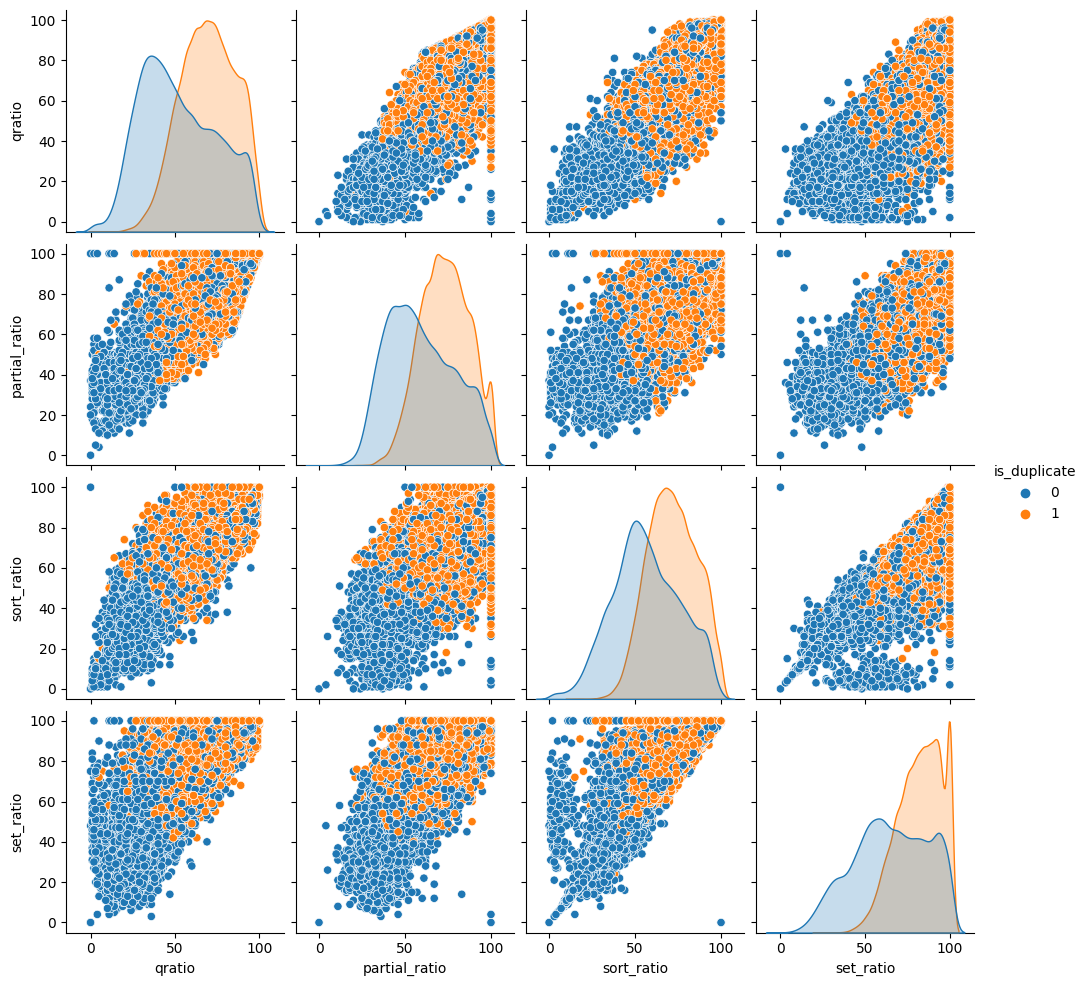

In [105]:
sns.pairplot(df[['qratio','partial_ratio', 'sort_ratio','set_ratio','is_duplicate']],hue='is_duplicate')

In [106]:
##using tsne for dimensionality reduction for 15 features (generated after feature engg) to 3 dimensions
from sklearn.preprocessing import MinMaxScaler
x = MinMaxScaler().fit_transform(df[['cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'first_word_similar', 'last_word_similar', 'abs_len_diff', 'mean_len',
       'longest_substr_ratio', 'qratio', 'partial_ratio', 'sort_ratio',
       'set_ratio']].values)
y = df['is_duplicate'].values 

In [107]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.139s...
[t-SNE] Computed neighbors for 50000 samples in 18.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [113]:
tsne_df = pd.DataFrame()
tsne_df['2dcol1'] = tsne2d[:,0]
tsne_df['2dcol2'] = tsne2d[:,1]
tsne_df['y'] = df['is_duplicate']

<Axes: xlabel='2dcol1', ylabel='2dcol2'>

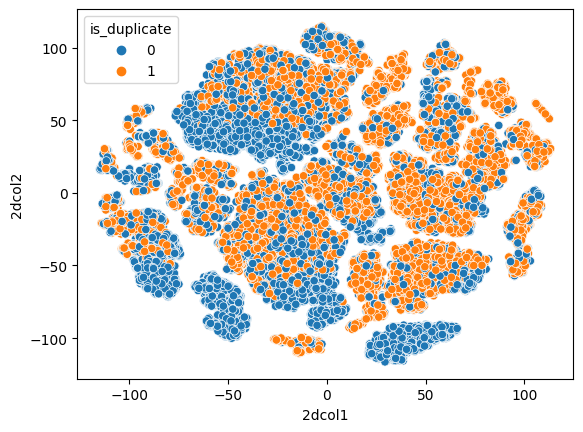

In [115]:
sns.scatterplot(x='2dcol1',y='2dcol2',data=tsne_df,hue=df['is_duplicate'])

In [116]:
tsne3d = TSNE(
    n_components=3,
    init='random', 
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.558s...
[t-SNE] Computed neighbors for 50000 samples in 18.661s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [118]:
tsne_df['3dcol1'] = tsne3d[:,0]
tsne_df['3dcol2'] = tsne3d[:,1]
tsne_df['3dcol3'] = tsne3d[:,2]

In [119]:
tsne_df.head()

,2dcol1,2dcol2,y,3dcol1,3dcol2,3dcol3
0,56.119503,92.311371,1,-24.958342,-14.777892,-11.737110
1,-34.335514,-21.377960,1,18.249048,-4.196777,3.445990
2,66.694771,-0.799522,1,-13.640189,2.218629,19.217899
3,-9.658300,85.313232,0,-1.458794,-15.665882,-8.869530
4,57.923744,-90.921188,0,12.956153,29.380657,6.486097


In [120]:
import plotly.express as px

In [123]:
fig=px.scatter_3d(tsne_df,x='3dcol1',y='3dcol2',z='3dcol3',color='y')
fig.show()

Output hidden; open in https://colab.research.google.com to view.